# Image classification of Breast Ultra Sound Images

Here we experiment with classical algorithms such as SVM and Bag of Visual words

### Import packages

In [120]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data, append_img_descriptors

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import NuSVC

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq

### Functions to assess model quality and to plot confusion matrix, ROC etc.

In [121]:
# Plot confusion matrix (binary)
def plot_cm(cm):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.title("Confusion matrix")
    plt.show()
    

# Plot ROC
def plot_ROC(fpr, tpr, auc):

    plt.figure(figsize = (6.4, 6.4))
    plt.plot(fpr, tpr, label= f"ROC, auc= {auc:.2f}")
    plt.title("ROC curve")
    plt.legend(loc=4)
    plt.show()
    

# To assess model quality analysis
def model_quality(model, X_train, X_test, y_train, y_test):

    # Accuracy
    print(f"Model accuracy on training data: {model.score(X_train, y_train):.2f} ")
    print(f"Model accuracy on test data: {model.score(X_test, y_test):.2f} ")

    # Classification report (precision, recall, f1 score)
    print(f"\nClassification report:\n {classification_report(y_test, model.predict(X_test))} ")

    # Confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    print(f"Confusion matrix:\n {cm}\n")
    plot_cm(cm)

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plot_ROC(fpr, tpr, auc)

# Get indices for True positives, True negatives, False positives and False negatives
def get_indices(model, X, y):

    y_pred = model.predict(X)
    tp_index = np.argwhere( (y == 1) & (y_pred == 1))
    tn_index = np.argwhere( (y == 0) & (y_pred == 0))
    fp_index = np.argwhere( (y == 0) & (y_pred == 1))
    fn_index = np.argwhere( (y == 1) & (y_pred == 0))

    return (tp_index, tn_index, fp_index, fn_index)


## Read image list (with dict object for each image) for the 2 classes (Benign and Malignant)
 - Read benign and malignant dataset into a list

In [122]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of all images in a image directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Bag of Visual words

### Visualize SIFT and ORB feature descriptors for sample images

Image:  [ndim, shape, dtype, min, max]: [2, (256, 256), uint8, 0, 255]
Number of SIFT keypoints: 201
SIFT descriptors [ndim, shape, dtype, min, max]: [2, (201, 128), float32, 0.0, 210.0]
Number of ORB keypoints: 344
ORB descriptors [ndim, shape, dtype, min, max]: [2, (344, 32), uint8, 0, 255]


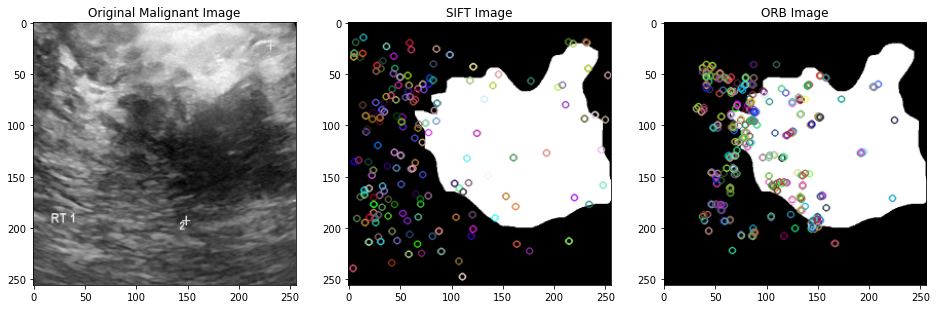

In [123]:
img_file = './Dataset_BUSI_with_GT/malignant_256/malignant (2)_256.png'
img_mask_file = './Dataset_BUSI_with_GT/malignant_256/malignant (2)_256_mask.png'

img = img_read(img_file, toFloat = False)
img_mask = img_read(img_mask_file, toFloat = False)
print_ndarray_info(img, "Image: ")

# SIFT feature extractor
sift = cv2.SIFT_create(nfeatures=200)
keypoints, descriptors = sift.detectAndCompute(img, None)
print(f"Number of SIFT keypoints: {len(keypoints)}")
print_ndarray_info(descriptors, "SIFT descriptors")
# Draw the detected key points
sift_image = cv2.drawKeypoints(img_mask, keypoints, 0, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# ORB feature extractor
orb = cv2.ORB_create(nfeatures=400)
keypoints, descriptors = orb.detectAndCompute(img, None)
print(f"Number of ORB keypoints: {len(keypoints)}")
print_ndarray_info(descriptors, "ORB descriptors")
# Draw the detected key points
orb_image = cv2.drawKeypoints(img_mask, keypoints, 0, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

display_3_imgs([img, sift_image, orb_image], ["Original Malignant Image", "SIFT Image", "ORB Image"])

## Prepare data for Bag of Visual Words classification
 - Extract feature descriptors using SIFT or ORB
 - Cluster features using K means, clusters become the visual words
 - Generate feature data (how many of each visual words occur in an image)
 - Split the data in to training and test (70-30) set
 - Scale the data (use Standard scaler)

In [178]:
# SIFT for each image returns us a m×128 dimension array, where m is the number of features extrapolated.
# ORB for each image returns us a m×32 dimension array, where m is the number of features extrapolated.
descriptor_type, nfeatures, fdim= 'SIFT', 800, 128
#descriptor_type, nfeatures, fdim= 'ORB', 800, 32
img_descriptors = np.empty((0, fdim), np.int32)
img_descriptors_list = []

#img_list = malignant_img_list_all[0:3:2]
img_list = benign_img_list_all + malignant_img_list_all
img_descriptors, img_descriptors_list = append_img_descriptors(img_list, img_descriptors, img_descriptors_list, descriptor_type, nfeatures)

img_descriptors= img_descriptors.astype(np.float32)
print_ndarray_info(img_descriptors, "Image descriptors float")

Image descriptors float [ndim, shape, dtype, min, max]: [2, (491383, 128), float32, 0.0, 255.0]


In [179]:
# K means clustering
k = 400
voc, variance = kmeans(img_descriptors, k, 1)

In [180]:
# Create features using histogram of images
# Cluster is a features (visual words), and num of clusters = number of features
# Each feature in feature vectors is a count of the visual representing that feature
img_features = np.zeros((len(img_list),k), np.float32)
for i in range(len(img_list)):
    words, distance = vq(img_descriptors_list[i], voc)
    for w in words:
        img_features[i][w] += 1

# Create labels - 0 for benign and 1 for malignant
img_labels = np.array([0]*num_benign_img, dtype= np.int32)
img_labels = np.append(img_labels, np.array([1]*num_malignant_img, dtype= np.int32))

# Indices are used to recover images after shuffling
# indices 0 to num_benign_img - 1 is from benign and rest for malignant
indices = np.arange(0, num_benign_img + num_malignant_img, dtype= np.int32)

X, y = img_features, img_labels
print_ndarray_info(X, "img_features")
print_ndarray_info(y, "img_labels")

img_features [ndim, shape, dtype, min, max]: [2, (857, 400), float32, 0.0, 21.0]
img_labels [ndim, shape, dtype, min, max]: [1, (857,), int32, 0, 1]


In [181]:
# Shuffle and split data (keep same proportions of positive and negative in training and test set)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.3, random_state= 7, stratify= y)

# Scale training data and transform the test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1. Use Logistic regression on ORB features
#### C = 1.0 (Inverse of regularization strength)

In [182]:
# Create a model and train
# solver= 'liblinear' 'lbfgs'
model = LogisticRegression(solver= 'liblinear', C= 1.0, random_state= 0)
#model = LinearSVC(C= 1.0, random_state= 0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.72 

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       132
           1       0.71      0.71      0.71       126

    accuracy                           0.72       258
   macro avg       0.72      0.72      0.72       258
weighted avg       0.72      0.72      0.72       258
 
Confusion matrix:
 [[96 36]
 [36 90]]



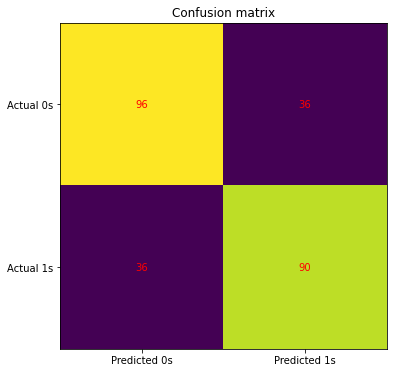

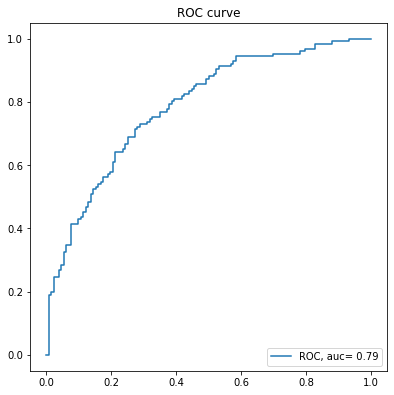

In [183]:
# Assess model quality
model_quality(model, X_train, X_test, y_train, y_test)

### 1. Logistic regression on ORB features
#### Fine tune Logistic regression using Gridsearch

In [186]:
# Define parameter range 'solver': ['liblinear', 'lbfgs', 'newton-cg'] 'penalty':  ['l1', 'l2']
param_grid = {'penalty':  ['l1', 'l2'],
              'C': [0.001, .005, 0.01, 0.05, 0.1, 1.0]
             }

grid = GridSearchCV(LinearSVC(), param_grid, scoring= 'accuracy', refit= True, verbose= 3)
# SVC(kernel='linear'), LinearSVC(), LogisticRegression(random_state= 0)

# Fit the model using grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.750 total time=   0.0s
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.758 total time=   0.0s
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.767 total time=   0.0s
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.750 total time=   0.0s
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.723 total time=   0.0s
[CV 1/5] END .................C=0.005, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.005, penalty=l

c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

[CV 3/5] END ...............C=0.005, penalty=l2;, score=0.733 total time=   0.0s
[CV 4/5] END ...............C=0.005, penalty=l2;, score=0.717 total time=   0.0s
[CV 5/5] END ...............C=0.005, penalty=l2;, score=0.739 total time=   0.0s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.683 total time=   0.0s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.725 total time=   0.0s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.717 total time=   0.0s


c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

[CV 4/5] END ................C=0.01, penalty=l2;, score=0.700 total time=   0.0s
[CV 5/5] END ................C=0.01, penalty=l2;, score=0.739 total time=   0.0s
[CV 1/5] END ..................C=0.05, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.05, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=0.05, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=0.05, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=0.05, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ................C=0.05, penalty=l2;, score=0.675 total time=   0.0s
[CV 2/5] END ................C=0.05, penalty=l2;, score=0.742 total time=   0.0s


c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

[CV 3/5] END ................C=0.05, penalty=l2;, score=0.717 total time=   0.0s
[CV 4/5] END ................C=0.05, penalty=l2;, score=0.692 total time=   0.0s
[CV 5/5] END ................C=0.05, penalty=l2;, score=0.723 total time=   0.0s
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.683 total time=   0.0s


c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

[CV 2/5] END .................C=0.1, penalty=l2;, score=0.733 total time=   0.0s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.717 total time=   0.0s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.683 total time=   0.0s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.723 total time=   0.0s
[CV 1/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s


c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "c:\Users\shahk\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

[CV 5/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=1.0, penalty=l2;, score=0.683 total time=   0.0s
[CV 2/5] END .................C=1.0, penalty=l2;, score=0.725 total time=   0.0s
[CV 3/5] END .................C=1.0, penalty=l2;, score=0.742 total time=   0.0s
[CV 4/5] END .................C=1.0, penalty=l2;, score=0.683 total time=   0.0s
[CV 5/5] END .................C=1.0, penalty=l2;, score=0.714 total time=   0.0s


c:\Users\shahk\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.74953782        nan 0.72123249        nan 0.71289916
        nan 0.70953782        nan 0.70787115        nan 0.70952381]
  warnings.warn(


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=3)

### 1. Logistic regression with ORB features
#### Assess the quality of the best model from Gridsearch

Best model parameters:  {'C': 0.001, 'penalty': 'l2'}
Model accuracy on training data: 0.92 
Model accuracy on test data: 0.76 

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77       132
           1       0.75      0.77      0.76       126

    accuracy                           0.76       258
   macro avg       0.76      0.76      0.76       258
weighted avg       0.76      0.76      0.76       258
 
Confusion matrix:
 [[100  32]
 [ 29  97]]



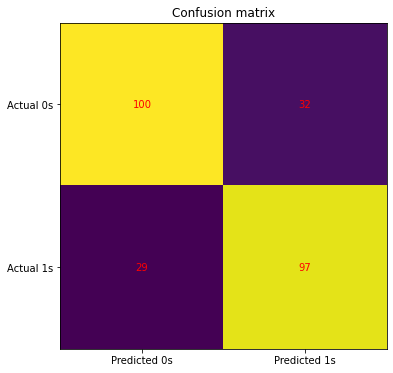

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [187]:
# Print best parameter after tuning 
print("Best model parameters: ", grid.best_params_)
model_best = grid.best_estimator_
# Assess model quality
model_quality(model_best, X_train, X_test, y_train, y_test)